# Importação das bibliotecas

In [1]:
import geopandas as gpd
import pandas as pd
import folium
from folium.plugins import HeatMap, MarkerCluster, Fullscreen

# Coleta dos dados

In [2]:
# dados = https://www.ibge.gov.br/geociencias/downloads-geociencias.html?caminho=organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/2021/Malha_de_setores_%28shp%29_por_UFs
# dados = https://cdn3.gnarususercontent.com.br/3061-dados-geograficos-folium/dados.csv
rj = gpd.read_file("33SEE250GC_SIR.shp")
imoveis = pd.read_csv("dados.csv", sep = "\t")



# Fazendo a limpeza e filtragem dos dados

In [3]:
cidade_rio = rj[rj["NM_MUNICIP"]== "RIO DE JANEIRO"] 
cidade_rio_copy = cidade_rio.copy()
cidade = cidade_rio_copy.dissolve(by = "NM_MUNICIP")

bairros_rio = cidade_rio_copy.dissolve(by = "NM_BAIRRO")

imoveis = gpd.GeoDataFrame(imoveis, geometry= gpd.points_from_xy(imoveis["Longitude"], imoveis["Latitude"]))
imoveis= imoveis[imoveis["geometry"].within(cidade["geometry"].iloc[0])]
imoveis.insert(0, "cor", pd.qcut(imoveis["Valor"], q=[0, 0.5, 0.75, 1], labels = ["red", "orange", "green"]))
imoveis.insert(0, "NM_BAIRRO", "")

bairros_rio_copy = bairros_rio.copy()
bairro_rio = bairros_rio_copy.reset_index()
geo_bairros = bairro_rio[["NM_BAIRRO", "geometry"]]

for index in range(len(bairro_rio)):
    imoveis.loc[imoveis["geometry"].within(bairro_rio["geometry"].iloc[index]), "NM_BAIRRO"] = bairro_rio["NM_BAIRRO"].iloc[index]
    
estatisticas_bairros = imoveis.groupby("NM_BAIRRO")[["Valor", "Tipo", "Area"]].agg({"Valor":['min', "mean", "max"], "Tipo": "count", "Area":["min", "max"]})
estatisticas_bairros = estatisticas_bairros.droplevel(level=0, axis=1).reset_index()
estatisticas_bairros.columns= ["NM_BAIRRO", "preco_min", "preco_medio", "preco_max", "qtd_imoveis", "area_min", "area_max"]
estatisticas_bairros = gpd.GeoDataFrame(estatisticas_bairros.merge(geo_bairros, on = "NM_BAIRRO", how= "left"))


# Criação das funções que gera os mapas

In [4]:
def mapa(cidade,bairros_rio):
    mapa_rio = folium.Map(location =[ -22, -43], zoom_start =8, tiles="Cartodb Positron")
    folium.GeoJson(bairros_rio).add_to(mapa_rio)

    mapa_rio_1 = folium.Map(location =[ -22, -43], zoom_start =8, tiles="Cartodb Positron")
    folium.GeoJson(cidade).add_to(mapa_rio_1)
    
    
    return mapa_rio, mapa_rio_1

def mapa_calor(imoveis,bairros_rio):
    mapa_rio_calor = folium.Map(location =[imoveis["Latitude"].mean(), imoveis["Longitude"].mean()], zoom_start =10, tiles="Cartodb dark_matter")

    estilo = {"fillOpacity":0, "color":"#ffffff", "weight":0.5}

    HeatMap(data = imoveis[["Latitude", "Longitude"]], name= "Mapa de Calor",radius= 20).add_to(mapa_rio_calor)
    folium.GeoJson(bairros_rio, name="Rio de Janeiro", style_function= lambda x: estilo).add_to(mapa_rio_calor)

    estilo_borda_preta = {"fillOpacity":0, "color":"#000000", "weight":0.5}

    HeatMap(data = imoveis[["Latitude", "Longitude"]], name= "Mapa de Calor (vermelho)",radius= 20, gradient={0:"grey", 1:"red"}, show= False).add_to(mapa_rio_calor)
    folium.GeoJson(bairros_rio, name="Rio de Janeiro (Borda preta)", style_function= lambda x: estilo_borda_preta, show=False).add_to(mapa_rio_calor)

    folium.TileLayer("Cartodb Positron", name= "Positron").add_to(mapa_rio_calor)
    folium.LayerControl().add_to(mapa_rio_calor)
    return mapa_rio_calor

def mapa_calor_bairros(imoveis,bairros_rio):
    mapa_rio_calor_bairro = folium.Map(location =[imoveis["Latitude"].mean(), imoveis["Longitude"].mean()], zoom_start =10, tiles="Cartodb dark_matter")
    estilo = {"fillOpacity":0, "color":"#ffffff", "weight":0.5}
    HeatMap(data = imoveis[["Latitude", "Longitude"]], name= "Mapa de Calor",radius= 20).add_to(mapa_rio_calor_bairro)

    for indice, linha in bairros_rio.iterrows():
        bairro = gpd.GeoDataFrame(pd.DataFrame(linha).T, geometry= "geometry", crs= "EPSG:4674")
        folium.GeoJson(bairro, name= bairro.index[0], style_function= lambda x: estilo, tooltip=bairro.index[0]).add_to(mapa_rio_calor_bairro)

    folium.LayerControl().add_to(mapa_rio_calor_bairro)

    mapa_rio_calor_bairro.save("mapa_calor_rio.html")
    return mapa_rio_calor_bairro

def mapa_pin_cluster(imoveis,bairros_rio):
    mapa_rio_pin_cluster = folium.Map(location =[imoveis["Latitude"].mean(), imoveis["Longitude"].mean()], zoom_start =10, tiles="Cartodb dark_matter")
    estilo = {"fillOpacity":0, "color":"#ffffff", "weight":0.5}

    for indice, linha in bairros_rio.iterrows():
        bairro = gpd.GeoDataFrame(pd.DataFrame(linha).T, geometry= "geometry", crs= "EPSG:4674")
        folium.GeoJson(bairro, name= bairro.index[0], style_function= lambda x: estilo, tooltip=bairro.index[0]).add_to(mapa_rio_pin_cluster)


    cluster = MarkerCluster()

    # Os tipos de ícones que podem ser usados podem ser encontrados em dois sites:Font Awesome,Bootstrap 3

    imoveis.apply(
        lambda linha: folium.Marker(
            location=[linha["Latitude"],
                    linha["Longitude"]], 
            icon = folium.Icon(color =linha["cor"], icon = "fa-home", prefix="fa"), 
            popup=folium.Popup(f'''<b>Bairro</b>:{linha["Bairro"]}<br>
                                <b>Área</b>:{linha["Area"]} m²<br>
                                <b>Valor</b>: R$ {linha["Valor"]/1000} k <br>
                                <b>Quartos</b>: {linha["Quartos"]}
                                ''',
                                max_width=200, 
                                sticky=True)
                                ).add_to(cluster), axis=1)

    cluster.add_to(mapa_rio_pin_cluster)
    folium.LayerControl().add_to(mapa_rio_pin_cluster)

    mapa_rio_pin_cluster.save("mapa_calor_rio.html")
    return mapa_rio_pin_cluster

def mapa_final(imoveis,bairro_rio, estatisticas_bairros):
    mapa_final = folium.Map(location =[imoveis["Latitude"].mean(), imoveis["Longitude"].mean()], zoom_start =10, tiles="Cartodb Positron")

    folium.Choropleth(geo_data=bairro_rio,
                    data= estatisticas_bairros,
                    columns= ["NM_BAIRRO", "preco_medio"],
                    key_on="feature.properties.NM_BAIRRO",
                    fill_color="YlOrRd",
                    nan_fill_color="white",
                    bins=10,
                    highlight=True,
                    legend_name="Media do valor do imovel").add_to(mapa_final)

    cluster = MarkerCluster()

    # Os tipos de ícones que podem ser usados podem ser encontrados em dois sites:Font Awesome,Bootstrap 3

    imoveis.apply(
        lambda linha: folium.Marker(
            location=[linha["Latitude"],
                    linha["Longitude"]], 
            icon = folium.Icon(color =linha["cor"], icon = "fa-home", prefix="fa"), 
            popup=folium.Popup(f'''<b>Bairro</b>:{linha["Bairro"]}<br>
                                <b>Área</b>:{linha["Area"]} m²<br>
                                <b>Valor</b>: R$ {linha["Valor"]/1000} k <br>
                                <b>Quartos</b>: {linha["Quartos"]}
                                ''',
                                max_width=200, 
                                sticky=True)
                                ).add_to(cluster), axis=1)

    cluster.add_to(mapa_final)

    Fullscreen().add_to(mapa_final)
    mapa_final

    style_function = lambda x: {'fillColor': "#ffffff",
                                "color":"#000000",
                                "fillOpacity":0.1,
                                "weight":0.1}
    highlight_function= lambda x:{"fillColor": "#000000",
                                "color": "#000000",
                                "fillOpacity":0.5,
                                "weight":0.1}

    config = folium.features.GeoJson(
        estatisticas_bairros,
        style_function=style_function,
        highlight_function=highlight_function,
        tooltip= folium.features.GeoJsonTooltip(
            fields= ["NM_BAIRRO", "preco_min", "preco_medio", "preco_max", "qtd_imoveis", "area_min", "area_max"],
            aliases= ["Bairro: ", "Preço mínimo: ", "Preço médio: ", "Preço máximo: ", " Quantide de imóveis", "Área mínima: ", "Área máxima: "],
            style=("background-color: white; color:#333333; font-family: arial; font-size: 12px; padding: 10px;")
        )
    )

    mapa_final.add_child(config)
    mapa_final.keep_in_front(config)

    mapa_final.save("mapa_imoveis_rio.html")
    return mapa_final


# Visualização simples da distribuição dos imoveis

<Axes: >

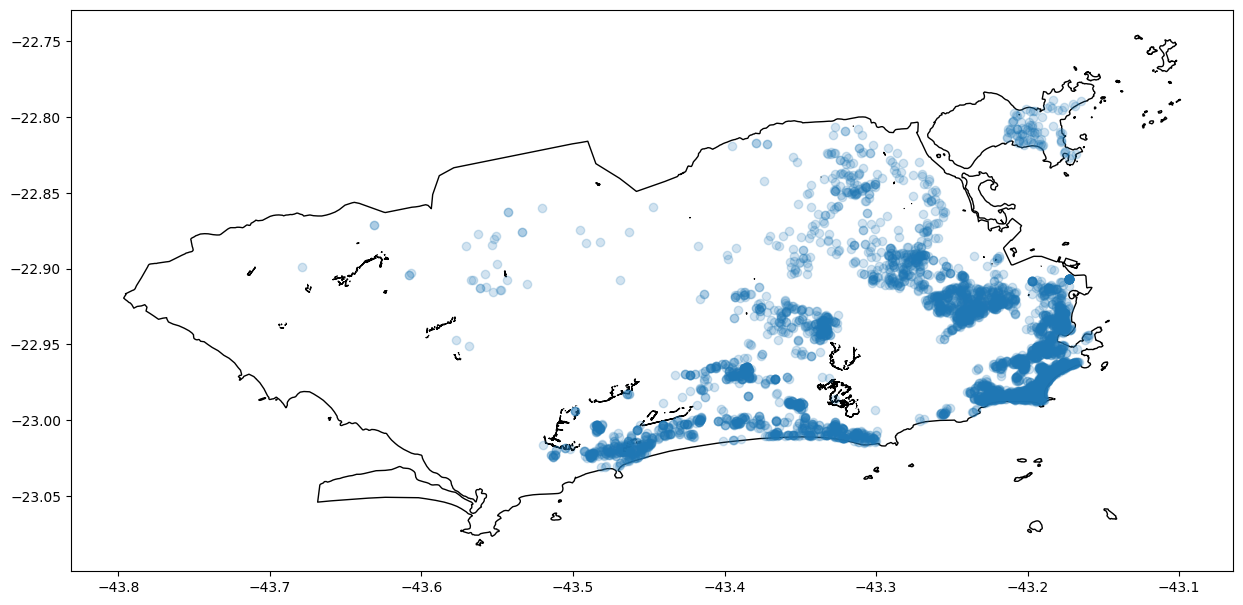

In [5]:
base = cidade.plot(color = "white", edgecolor= "black", figsize= (15,8))
imoveis.plot(ax= base, alpha = 0.2)

# Criando os gráficos como variáveis para uso posterior

In [6]:
mapa_rio, mapa_rio_1 = mapa(cidade,bairros_rio)
mapa_rio_calor = mapa_calor(imoveis,bairros_rio)
mapa_rio_calor_bairro= mapa_calor_bairros(imoveis,bairros_rio)
mapa_rio_pin_cluster= mapa_pin_cluster(imoveis,bairros_rio)
mapa_final = mapa_final(imoveis,bairro_rio, estatisticas_bairros)